In [1]:
!nvidia-smi

Mon Apr 10 01:31:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 加载数据

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time

CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

def downloadCIFAR():
    if not os.path.exists('../data'):
        os.system('mkdir ../data')
        print('make dic')
    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('downloading CIFAR')
        os.system('wget {}'.format(CIFAR_URL))
        os.system('mv ./cifar-10-python.tar.gz ../data/cifar-10-python.tar.gz')
    else:
        print('CIFAR exist')
    if not os.path.exists('../data/cifar-10-batches-py'):
        print('unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
    else:
        print('CIFAR unpacked')
        
downloadCIFAR()

make dic
downloading CIFAR
unpacking CIFAR


## 数据处理

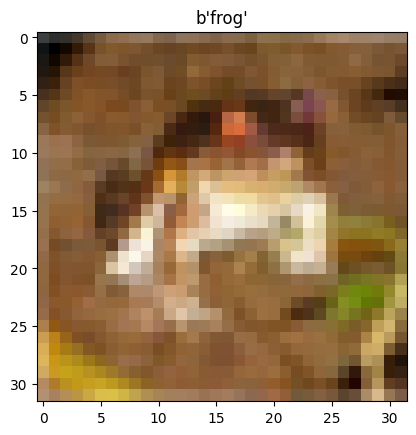

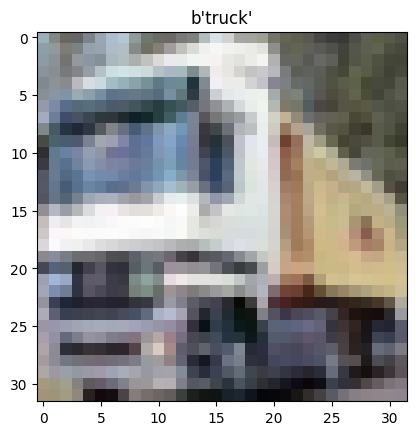

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def show_img(num):
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    label = info[b'label_names'][dict[b'labels'][num]]
    
    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()

for i in range(2):
    show_img(i)

In [4]:
def get_label_data(train_val, num=0):
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'], 
                                                                                dtype=torch.float32).reshape(10000, 3, 32, 32)

def load_data():
    for i in range(5):
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])


> 至此为止我们创建了一系列的数据，包括`train_labels, train_data, test_labels, test_data`，他们的形式都是tensor，下面我们将会用LeNet去简单测试一下

## 模型定义

In [19]:
class LinearNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LinearNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2), # 10x3x32x32 -> 10x6x32x32
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2), # 10x6x32x32 -> 10x6x16x16
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0), # 10x6x16x16 -> 10x16x12x12
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 10x16x12x12 -> 10x16x6x6
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(inplace=True), # inplace=True means that it will modify the input directly
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2), # 10x3x32x32 -> 10x64x17x17
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 10x64x17x17 -> 10x64x8x8
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2), #  10x64x8x8 -> 10x192x8x8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 10x192x8x8 -> 10x192x3x3

            nn.Conv2d(192, 384, kernel_size=3, padding=1), # 10x192x3x3 -> 10x384x3x3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 10x384x3x3 -> 10x256x3x3
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # 10x256x3x3 -> 10x256x3x3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 10x256x3x3 -> 10x256x1x1
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [6]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from torchinfo import summary

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
# model = LeNet()
# model = LinearNet()
model.to(device)
summary(model, input_size=(10, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [10, 10]                  --
├─Sequential: 1-1                        [10, 256, 1, 1]           --
│    └─Conv2d: 2-1                       [10, 64, 17, 17]          1,792
│    └─ReLU: 2-2                         [10, 64, 17, 17]          --
│    └─MaxPool2d: 2-3                    [10, 64, 8, 8]            --
│    └─Conv2d: 2-4                       [10, 192, 8, 8]           307,392
│    └─ReLU: 2-5                         [10, 192, 8, 8]           --
│    └─MaxPool2d: 2-6                    [10, 192, 3, 3]           --
│    └─Conv2d: 2-7                       [10, 384, 3, 3]           663,936
│    └─ReLU: 2-8                         [10, 384, 3, 3]           --
│    └─Conv2d: 2-9                       [10, 256, 3, 3]           884,992
│    └─ReLU: 2-10                        [10, 256, 3, 3]           --
│    └─Conv2d: 2-11                      [10, 256, 3, 3]           

## 开始训练

### Trainer

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

class Trainer:
    def __init__(self, model, X, y, num_epochs, batch_size, loss_fn, optimizer, n_splits=5, is_print=True, print_every=10):
        self.train_losses_per_fold = [] # 记录每个fold的训练损失
        self.test_losses_per_fold = [] # 记录每个fold的测试损失
        self.mean_train_losses = np.zeros(num_epochs) # 记录每个epoch的平均训练损失
        self.mean_test_losses = np.zeros(num_epochs) # 记录每个epoch的平均测试损失
        
        self.model = model

        self.X = X
        self.y = y

        self.num_epochs = num_epochs
        self.batch_size = batch_size

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.n_splits = n_splits

        self.is_print = is_print
        self.print_every = print_every
        pass

    
    def reset_parameters(self, model):
        # 重置模型参数
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
                print("reset_parameters")

    def reset_model(self):
        # 重置模型参数为最开始初始化的参数
        self.model.load_state_dict(torch.load("model.pth"))

    def train_kfold(self):
        # 保存模型
        torch.save(self.model.state_dict(), "model.pth")

        kf = KFold(n_splits=self.n_splits) # 创建KFold对象

        # 开始交叉验证循环
        for fold_index, (train_index, test_index) in enumerate(kf.split(self.X)):
            if self.is_print:
                print(f"Fold {fold_index}")

            # self.model.apply(self.reset_parameters) # 重置模型参数为最开始初始化的参数
            self.reset_model() # 重置模型参数为最开始初始化的参数
                
            X_train = self.X[train_index] # 训练集特征
            y_train = self.y[train_index] # 训练集标签
            X_test = self.X[test_index] # 测试集特征
            y_test = self.y[test_index] # 测试集标签

            train_loss_history = [] # 记录训练损失
            test_loss_history = [] # 记录测试损失
            
            train_dataset = TensorDataset(X_train, y_train) # 创建训练集数据集对象
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size) # 创建训练集数据加载器对象
            
            test_dataset = TensorDataset(X_test, y_test) # 创建测试集数据集对象
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size) # 创建测试集数据加载器对象

            
            for epoch in range(self.num_epochs): # 训练num_epochs个周期

                train_loss = 0
                test_loss = 0

                self.model.eval() # 设置模型为评估模式
                
                with torch.no_grad(): 
                    
                    for batch_X, batch_y in test_loader: 
                        
                        output = self.model(batch_X).squeeze()
                        
                        loss = self.loss_fn(output, batch_y)

                        test_loss += loss.item() * batch_y.shape[0] # 记录测试损失
                
                
                self.model.train() # 设置模型为训练模式

                for batch_X, batch_y in train_loader: # 遍历训练集批次
                    
                    self.optimizer.zero_grad() # 清空梯度
                    
                    output = self.model(batch_X).squeeze() # 前向传播，得到输出
                    
                    loss = self.loss_fn(output, batch_y) # 计算损失
                    
                    loss.backward() # 反向传播，计算梯度
                    
                    self.optimizer.step() # 更新参数

                    train_loss += loss.item() * batch_y.shape[0] # 记录训练损失

                mean_train_loss = train_loss / X_train.shape[0] # 计算平均训练损失
                mean_test_loss = test_loss / X_test.shape[0]# 计算平均测试损失
                
                if self.is_print and (epoch+1) % self.print_every == 0: # 每print_every个周期打印一次训练信息(损失
                    print(f"Epoch | {epoch+1:2d}/{self.num_epochs:2d} | Train Loss: {mean_train_loss:.4f} | Test Loss: {mean_test_loss:.4f}")

                train_loss_history.append(mean_train_loss) # 记录训练损失
                test_loss_history.append(mean_test_loss) # 记录测试损失

            self.train_losses_per_fold.append(train_loss_history) # 记录每个fold的训练损失
            self.test_losses_per_fold.append(test_loss_history) # 记录每个fold的测试损失

        self.mean_train_losses = np.mean(np.array(self.train_losses_per_fold), axis=0)
        self.mean_test_losses = np.mean(np.array(self.test_losses_per_fold), axis=0)

    def train_normal(self):
        X_train = self.X # 训练集特征
        y_train = self.y # 训练集标签

        train_loss_history = [] # 记录训练损失
        
        train_dataset = TensorDataset(X_train, y_train) # 创建训练集数据集对象
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size) # 创建训练集数据加载器对象
                
        for epoch in range(self.num_epochs): # 训练num_epochs个周期

            train_loss = 0
            
            self.model.train() # 设置模型为训练模式

            for batch_X, batch_y in train_loader: # 遍历训练集批次
                
                self.optimizer.zero_grad() # 清空梯度
                
                output = self.model(batch_X).squeeze() # 前向传播，得到输出
                
                loss = self.loss_fn(output, batch_y) # 计算损失
                
                loss.backward() # 反向传播，计算梯度
                
                self.optimizer.step() # 更新参数

                train_loss += loss.item() * batch_y.shape[0] # 记录训练损失

            mean_train_loss = train_loss / X_train.shape[0] # 计算平均训练损失

            if self.is_print and (epoch+1) % self.print_every == 0: # 每print_every个周期打印一次训练信息(损失
                print(f"Epoch | {epoch+1:2d}/{self.num_epochs:2d} | Train Loss: {mean_train_loss:.4f} ")

            train_loss_history.append(mean_train_loss) # 记录训练损失

        self.train_losses_per_fold.append(train_loss_history) # 记录每个fold的训练损失
    
    def visualize_kfold(self,width=30, height=6):
        # 绘制训练损失和测试损失
        plt.figure(figsize=(width, height))
        for i in range(self.n_splits):
            plt.subplot(1, self.n_splits, i+1)
            plt.plot(self.train_losses_per_fold[i], label=f"Train Loss Fold {i+1}")
            plt.plot(self.test_losses_per_fold[i], label=f"Test Loss Fold {i+1}")
            plt.legend()
        plt.show()

    def plot_mean_loss(self, width=10, height=6):
        # 绘制平均训练损失和平均测试损失 (所有fold的平均)
        plt.figure(figsize=(width, height))
        plt.plot(self.mean_train_losses, label="Mean Train Loss")
        plt.plot(self.mean_test_losses, label="Mean Test Loss")
        plt.legend()
        plt.show()
    
    def visualize_normal(self,width=10, height=6):
        # 绘制训练损失
        plt.figure(figsize=(width, height))
        plt.plot(self.train_losses_per_fold[0], label=f"Train Loss")
        plt.legend()
        plt.show()

    def predict(self, test_X):
        self.model.eval()
        with torch.no_grad():
            output = self.model(test_X).squeeze() # .squeeze()将输出的形状从[batch_size, 1]转换为[batch_size]
            return output

### 训练

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(
    model.to(device), 
    train_data.to(device), 
    train_labels.to(device), 
    num_epochs=10, 
    batch_size=128, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    n_splits=7, 
    is_print=True, 
    print_every=1
)

In [37]:
trainer.train_kfold()

Fold 0
Epoch |  1/10 | Train Loss: 2.0852 | Test Loss: 2.3510
Epoch |  2/10 | Train Loss: 1.6618 | Test Loss: 1.7732
Epoch |  3/10 | Train Loss: 1.4981 | Test Loss: 1.5459
Epoch |  4/10 | Train Loss: 1.4147 | Test Loss: 1.4242
Epoch |  5/10 | Train Loss: 1.3594 | Test Loss: 1.3628
Epoch |  6/10 | Train Loss: 1.3267 | Test Loss: 1.4763
Epoch |  7/10 | Train Loss: 1.2769 | Test Loss: 1.3445
Epoch |  8/10 | Train Loss: 1.2446 | Test Loss: 1.4000
Epoch |  9/10 | Train Loss: 1.2244 | Test Loss: 1.3140
Epoch | 10/10 | Train Loss: 1.2030 | Test Loss: 1.2775
Fold 1
Epoch |  1/10 | Train Loss: 2.5065 | Test Loss: 2.3550
Epoch |  2/10 | Train Loss: 1.7931 | Test Loss: 1.8643
Epoch |  3/10 | Train Loss: 1.6733 | Test Loss: 1.6828
Epoch |  4/10 | Train Loss: 1.6012 | Test Loss: 1.7178
Epoch |  5/10 | Train Loss: 1.5400 | Test Loss: 1.5860
Epoch |  6/10 | Train Loss: 1.4737 | Test Loss: 1.5393
Epoch |  7/10 | Train Loss: 1.4130 | Test Loss: 1.4243
Epoch |  8/10 | Train Loss: 1.3715 | Test Loss: 1.3

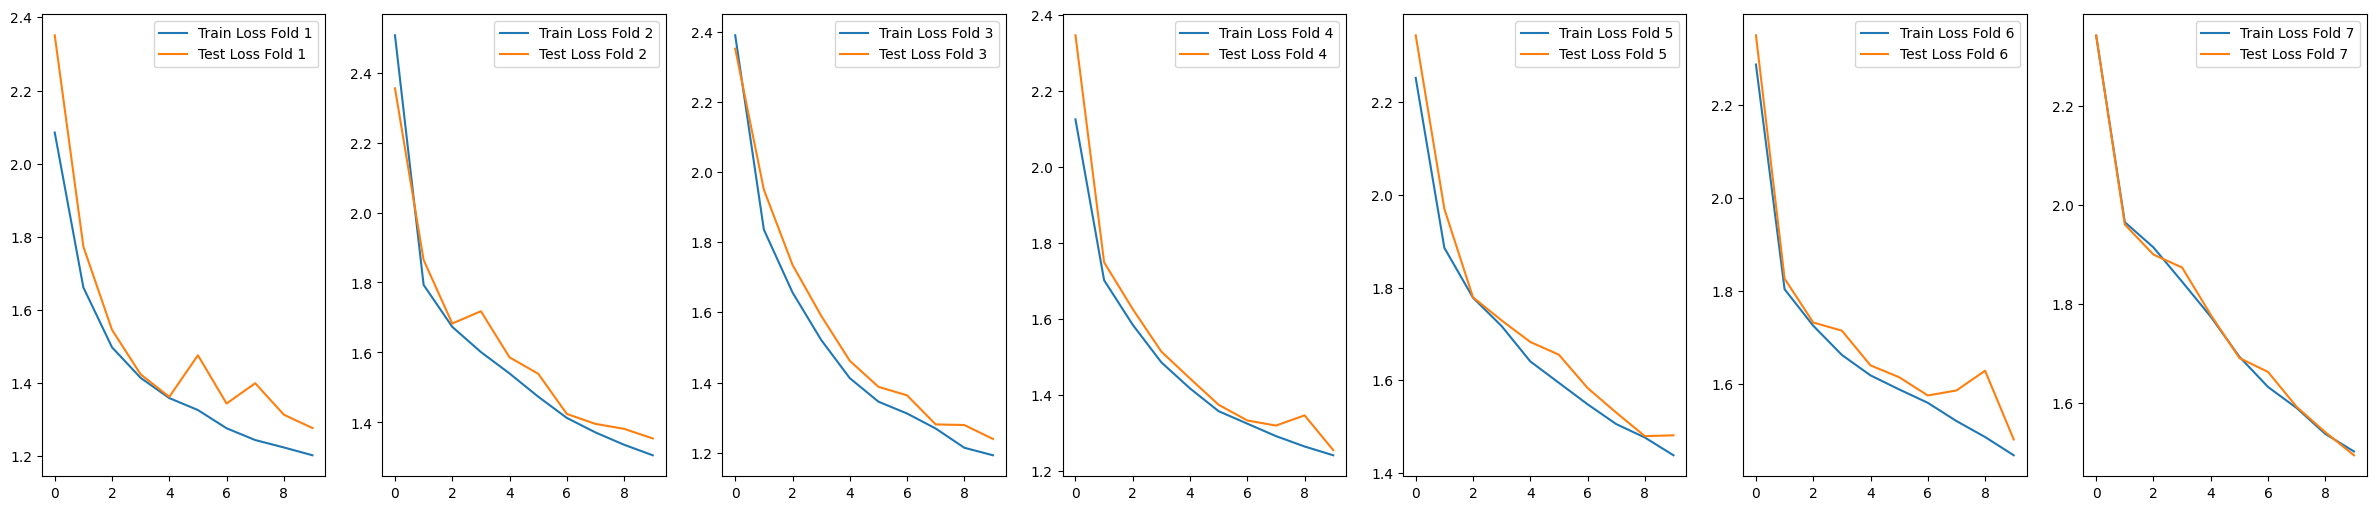

In [38]:
trainer.visualize_kfold()

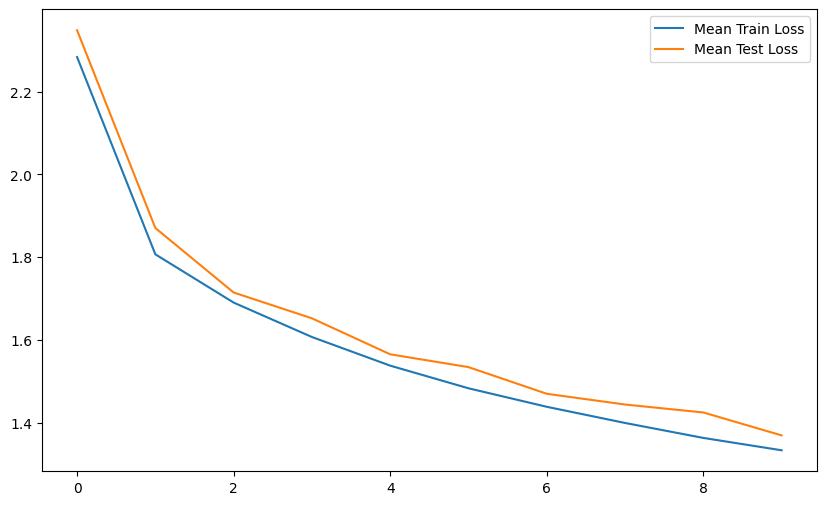

In [39]:
trainer.plot_mean_loss(width=10, height=6)

## 评估

In [48]:
def eval_train_and_test_acc():
  model.eval()

  with torch.no_grad():
      y_pred = model(train_data.to(device))
      y_pred = torch.softmax(y_pred, dim=1)  # dim=1表示对每一行进行softmax
      y_pred = torch.argmax(y_pred, dim=1)

      accuracy = torch.sum(y_pred == train_labels.to(device)).item() / len(train_labels)

  print(f"Train Accuracy: {accuracy:.2f}")

  with torch.no_grad():
      y_pred = model(test_data.to(device))
      y_pred = torch.softmax(y_pred, dim=1)
      y_pred = torch.argmax(y_pred, dim=1)

      accuracy = torch.sum(y_pred == test_labels.to(device)).item() / len(test_labels)

  print(f"Test Accuracy: {accuracy:.2f}")


eval_train_and_test_acc()

Train Accuracy: 0.10
Test Accuracy: 0.10


## 选定正确的model继续训练

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
model.to(device)
summary(model, input_size=(10, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [10, 10]                  --
├─Sequential: 1-1                        [10, 256, 1, 1]           --
│    └─Conv2d: 2-1                       [10, 64, 17, 17]          1,792
│    └─ReLU: 2-2                         [10, 64, 17, 17]          --
│    └─MaxPool2d: 2-3                    [10, 64, 8, 8]            --
│    └─Conv2d: 2-4                       [10, 192, 8, 8]           307,392
│    └─ReLU: 2-5                         [10, 192, 8, 8]           --
│    └─MaxPool2d: 2-6                    [10, 192, 3, 3]           --
│    └─Conv2d: 2-7                       [10, 384, 3, 3]           663,936
│    └─ReLU: 2-8                         [10, 384, 3, 3]           --
│    └─Conv2d: 2-9                       [10, 256, 3, 3]           884,992
│    └─ReLU: 2-10                        [10, 256, 3, 3]           --
│    └─Conv2d: 2-11                      [10, 256, 3, 3]           

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(
    model.to(device), 
    train_data.to(device), 
    train_labels.to(device), 
    num_epochs=10, 
    batch_size=128, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    n_splits=7, 
    is_print=True, 
    print_every=1
)

In [55]:
trainer.train_normal()

Epoch |  1/10 | Train Loss: 2.0616 
Epoch |  2/10 | Train Loss: 1.5714 
Epoch |  3/10 | Train Loss: 1.4237 
Epoch |  4/10 | Train Loss: 1.3430 
Epoch |  5/10 | Train Loss: 1.2901 
Epoch |  6/10 | Train Loss: 1.2437 
Epoch |  7/10 | Train Loss: 1.2061 
Epoch |  8/10 | Train Loss: 1.1787 
Epoch |  9/10 | Train Loss: 1.1508 
Epoch | 10/10 | Train Loss: 1.1210 


In [56]:
eval_train_and_test_acc()

Train Accuracy: 0.62
Test Accuracy: 0.58


In [60]:
trainer.train_normal()
eval_train_and_test_acc()

Epoch |  1/10 | Train Loss: 0.7734 
Epoch |  2/10 | Train Loss: 0.7391 
Epoch |  3/10 | Train Loss: 0.7200 
Epoch |  4/10 | Train Loss: 0.7208 
Epoch |  5/10 | Train Loss: 0.7080 
Epoch |  6/10 | Train Loss: 0.7069 
Epoch |  7/10 | Train Loss: 0.6929 
Epoch |  8/10 | Train Loss: 0.6925 
Epoch |  9/10 | Train Loss: 0.7061 
Epoch | 10/10 | Train Loss: 0.7007 
Train Accuracy: 0.76
Test Accuracy: 0.59


In [61]:
# 重新设定学习率，可以以后再想一下
trainer.optimizer.param_groups[0]['lr'] = 1e-4

In [66]:
trainer.train_normal()
eval_train_and_test_acc()

Epoch |  1/10 | Train Loss: 0.1083 
Epoch |  2/10 | Train Loss: 0.1074 
Epoch |  3/10 | Train Loss: 0.1041 
Epoch |  4/10 | Train Loss: 0.0986 
Epoch |  5/10 | Train Loss: 0.0944 
Epoch |  6/10 | Train Loss: 0.0958 
Epoch |  7/10 | Train Loss: 0.0950 
Epoch |  8/10 | Train Loss: 0.0923 
Epoch |  9/10 | Train Loss: 0.0888 
Epoch | 10/10 | Train Loss: 0.0840 
Train Accuracy: 0.97
Test Accuracy: 0.61


> 在这个文件中我们测试了前面定义的三个网络放在colab上用Tesla T4跑，就是LinearNet，LeNet，AlexNet，在num_epochs = 10, batch_size = 128, learning_rate(Adam) = 0.001, kfold = 7的情况下我们比较了这三个模型的训练过程中的现象以及最后的测试集和训练集的准确率。
> 我们可以从下面的数据中看出对比所在：


| 网络 | 训练集准确率 | 测试集准确率 | 评价 |
| --- | --- | --- | --- |
| LinearNet | 0.1 | 0.1 | 过于简单，无法拟合，最后loss不收敛，acc一直为0.1 |
| LeNet | 0.64 | 0.54 | 会有过拟合的现象产生，后面的话test_loss会开始上升，这里可能最好的准确率就在于0.54了 |
| AlexNet | 0.48 | 0.47 | 在前10个epoch中，test_loss和train_loss是在一直下降的，训练十轮下来的准确率虽然不如LeNet，但是也是可以接受的(进步空间比较大) |

后面我们就一直使用AlexNet来进行训练，这里的训练就不使用kfold，而是直接使用train_data和train_labels来进行训练，使用test_data和test_labels来进行测试。我们每次只训练十轮，并输出看一下模型的准确率如何。训练过程如下：

| epoch | train_acc | test_acc | 评价 |
| --- | --- | --- | --- |
| 10  | 0.62| 0.58| 看到train_loss和test_loss都在下降，继续训练|
| 20  | 0.66| 0.59| 看到train_loss和test_loss都在下降，继续训练|
| 30  | 0.71| 0.61| 看到train_loss和test_loss都在下降，继续训练|
| 40  | 0.66| 0.56| 不知道为什么这里出现了一次奇怪的波动（可能是colab上连接不稳定的问题）|
| 50  | 0.76| 0.59| train_loss开始反复波动了，这里结束后把学习率调小到1e-4|
| 60  | 0.90| 0.62| 这里看到的时候是很惊喜的，但训练集准确率上得那么快说明它可能也学不下去了|
| 70  | 0.94| 0.62| 测试集准确率上不去了|
| 80  | 0.95| 0.61| 测试集准确率上不去了|
| 90  | 0.96| 0.61| 测试集准确率上不去了|
| 100 | 0.97| 0.61| 测试集准确率上不去了|

> 最后的train_loss在0.144

但总体来说我们发现10 epoch和90 epoch的差别真的是不大，所以感觉这里做一个10 epoch的小demo看一下优越性就很好了。